
#Demo de uso de TF-Hub  para detectar múltiples objetos en una imagen
Basado en info de https://www.tensorflow.org/hub/tutorials/tf2_object_detection?hl=es-419 pero adaptada con funciones personalizadas para reducir dependencias (e incompatibilidades de versiones).

In [1]:
#@title Cargar Librerías

import os
import pathlib

import tensorflow as tf
import tensorflow_hub as hub

import random
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time
import os

import tensorflow_hub as hub

print("Librerías cargadas.")

Librerías cargadas.


In [10]:
#@title Define funciones auxiliares para procesar imágenes
# Nota: funciones adaptadas de https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py

# definición de colores standard para clases
STANDARD_COLORS = [
      'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
      'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
      'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
      'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
      'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
      'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
      'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
      'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
      'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
      'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
      'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
      'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
      'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
      'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
      'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
      'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
      'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
      'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
      'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
      'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
      'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
      'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
      'WhiteSmoke', 'Yellow', 'YellowGreen'
  ]


# config de keypoints  auxiliar
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]


def gen_class_random_color():
  return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])


def custom_load_labelmap(classPathFileName=None):
  if classPathFileName is None:
    # baja la definición de clases de msCOCO del repositorio de TF
    classPathFileName = 'mscoco_label_map.pbtxt'
    if not os.path.isfile( classPathFileName ):
      print("-- bajando clases por defecto de mscoco_label_map para usar --")
      !wget 'https://raw.githubusercontent.com/tensorflow/models/refs/heads/master/research/object_detection/data/mscoco_label_map.pbtxt'
    else:
      print("-- usa clases por defecto de mscoco_label_map ya bajada --")
  # lee la información del archivo
  if os.path.isfile( classPathFileName ):
      with open( classPathFileName, mode='r') as labelFile:
          fileContent = labelFile.read()
  #print(fileContent)
  # convierte a lista de items
  fileItemList = fileContent.split('item')
  ##print(fileItemList)
  # carga los items como dictionary
  label_dict = {}
  for item in fileItemList:
    # si está definido
    if len(item)>1:
      ##print(item)
      try:
        # parsea el item
        itLit = item.split("\n")
        it_id = int(itLit[2].split(": ")[1])
        #if use_display_name:
        it_display_name = itLit[3].split(": ")[1].replace('"', '')
        label_dict[it_id] = {}
        label_dict[it_id]["name"] = it_display_name
        # agrega color para clase
        label_dict[it_id]["color"] = STANDARD_COLORS[ it_id % len(STANDARD_COLORS)]
      except Exception as e:
        print("error al procesar", item, ":", e)
        continue
  ##print(label_dict)
  return label_dict


def draw_text_on_img(draw, display_str_list, box, color):
  (left, top, right, bottom) = box
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    return


def reframe_image_corners_relative_to_boxes(boxes):
  ymin, xmin, ymax, xmax = (boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3])
  height = tf.maximum(ymax - ymin, 1e-4)
  width = tf.maximum(xmax - xmin, 1e-4)
  ymin_out = (0 - ymin) / height
  xmin_out = (0 - xmin) / width
  ymax_out = (1 - ymin) / height
  xmax_out = (1 - xmin) / width
  return tf.stack([ymin_out, xmin_out, ymax_out, xmax_out], axis=1)


def reframe_box_masks_to_image_masks(box_masks, boxes, image_height,
                                     image_width, resize_method='bilinear'):
  resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""

    num_boxes = tf.shape(box_masks)[0]
    box_masks_expanded = tf.expand_dims(box_masks, axis=3)

    resized_crops = tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reframe_image_corners_relative_to_boxes(boxes),
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        method=resize_method,
        extrapolation_value=0)
    return tf.cast(resized_crops, box_masks.dtype)

  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
  return tf.squeeze(image_masks, axis=3)


def draw_mask_on_image(pil_image, mask, color='red', alpha=0.4):
  rgb = ImageColor.getrgb(color)
  solid_color = np.expand_dims(
      np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
  pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
  pil_mask = Image.fromarray(np.uint8(255.0*alpha*(mask > 0))).convert('L')
  pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
  return pil_image


def draw_box_on_image(draw, box, color, className=None, line_width=5):
    # dibuja en la imagen
    draw.rectangle(box, outline=color, width=line_width)
    # si tiene que incluir nombre clase
    if className is not None:
      draw_text_on_img(draw, [className], box, color)


def draw_keypoint_on_image(draw, keypoint_x, keypoint_y, color, radius=2, line_width=5):
    # dibuja en la imagen
    draw.ellipse([(keypoint_x - radius, keypoint_y - radius),
                    (keypoint_x + radius, keypoint_y + radius)],
                   outline=color, fill=color)


def procesarImagenNP(model, class_info, imag, min_score_display=0.15, \
                     mostrar_tiempo_ejecucion=False, mostrar_subimagenes_objetos=False):
      # determina tamaño imagen
      img_ancho, img_alto = imag.size
        # convierte imagen a vector
      converted_img = np.array(imag.getdata()).reshape(
          (1, img_alto, img_ancho, 3)).astype(np.uint8)
      # procesa la imagen en el modelo previamente cargado
      # devolviendo un vector con los resultados
      start_time = time.time()
      result = model(converted_img)
      end_time = time.time()
      # controla parámetros
      if min_score_display > 1:
        min_score_display = 0.9
      if min_score_display < 0:
        min_score_display = 0
      # prepara para visualizar los boxes
      result = {key:value.numpy() for key,value in result.items()}
      # preprocesa los mask de object segmentation si están disponibles
      if 'detection_masks' in result:
        mask_alpha=.4
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = reframe_box_masks_to_image_masks(
                  detection_masks, detection_boxes,
                  converted_img.shape[1], converted_img.shape[2])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                            tf.uint8)
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()
      # genera imagen PIL para dibujar en imagen
      image_with_objs = imag.copy() ## Image.fromarray(converted_img[0], 'RGB')
      # define clase para dibujar en imagen
      draw = ImageDraw.Draw(image_with_objs)
      # lista de objetos detectados
      objectsList = []
      # procesa los objetos detectados (boxes de object detection)
      for i in range(len(result['detection_boxes'][0])):
        # define valores
        detscore = result['detection_scores'][0][i]
        detbox = result['detection_boxes'][0][i]
        classId = int(result['detection_classes'][0][i])
        # analiza score
        if detscore >= min_score_display:
            # determina clase
            if (class_info is not None) and (classId in class_info):
              className = class_info[classId]["name"]
              classColor = class_info[classId]["color"]
            else:
              className = "CLASS " + str(classId)
              classColor = gen_class_random_color()
            # como las coordenadas están normalizadas las debe convertir
            # teniendo en cuenta el tamaño de la imagen
            # además notar que vienen datas en otro orden
            # - detBox = (ini alto, ini ancho, fin alto, fin ancho)
            # - nuevoRangoIn = (ini ancho, ini alto, fin ancho, fin alto)
            nbox = (detbox[1] * img_ancho,
                    detbox[0] * img_alto,
                    detbox[3] * img_ancho,
                    detbox[2] * img_alto)
            # dibuja box en la imagen
            draw_box_on_image(draw,
                              box=nbox,
                              color=classColor,
                              className=className)
            # procesa keypoints del box si están disponibles
            if 'detection_keypoints' in result:
                detkeypointsList = []
                for keypoints, keypoint_score in zip(result['detection_keypoints'][0][i], result['detection_keypoint_scores'][0][i]):
                  # dibuja keypoint
                  if keypoint_score >= min_score_display:
                    # convierte coordenadas normalizadas
                    keyp_x = img_ancho * keypoints[1]
                    keyp_y = img_alto * keypoints[0]
                    # dibuja en la imagen
                    draw_keypoint_on_image(draw,
                                          keypoint_x=keyp_x, keypoint_y=keyp_y,
                                          color=classColor)
                    # registra el keypoint detectado
                    detkeypointsList.append( [keyp_x, keyp_y] )
            else:
                detkeypointsList = None
            # procesa los mask de object segmentation reframed si están disponibles
            if 'detection_masks_reframed' in result:
              # agrega el mask
              detmask = result['detection_masks_reframed'][i]
              image_with_objs = draw_mask_on_image(
                                                image_with_objs,
                                                detmask,
                                                color=classColor,
                                                alpha=mask_alpha
                                            )
              # vuelve a generar el draw sobre la nueva imagens
              draw = ImageDraw.Draw(image_with_objs)
            else:
              detmask = None
            # registra el objeto detectado
            objectsList.append( { "classId": classId, "class": className,
                                  "box": nbox, "score": detscore,
                                  "color": classColor,
                                  "mask" : detmask,
                                  "keypoints": detkeypointsList} )

      # muestra la imagen con los objetos detectados
      display( image_with_objs )
      print(" -- Objetos mostrados: %d de %d detectados total" % (len(objectsList), len(result["detection_boxes"][0])) )
      if mostrar_tiempo_ejecucion:
        print(" -- Tiempo de procesamiento: %3.2f segundos " % (end_time - start_time))
      if mostrar_subimagenes_objetos:
        print("\n ** Sub-Imágenes:")
        # genera otra imagen "limpia" para extraer sub-imágenes
        img_crop = imag.copy() ##Image.fromarray(converted_img[0], 'RGB')
        draw = ImageDraw.Draw(img_crop)
        # muestra detalle de los objetos mostrados
        for ob in objectsList:
            print("\n\t* clase ", ob["class"], "con", round(ob["score"]*100,1), "% en box ", ob["box"])
            # si tiene keypoints los agrega
            if ob["keypoints"] is not None:
                print("\n\t  incluye keypoints %d mostrados " %  len(ob["keypoints"]))
                for kpt in ob["keypoints"]:
                    draw_keypoint_on_image(draw,
                                          keypoint_x=kpt[0], keypoint_y=kpt[1],
                                          color=ob["color"])
            display ( img_crop.crop(ob["box"]) )

      return objectsList

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Nueva sección

In [12]:
#@title Seleccionar el modelo de TF-Hub a utilizar

seleccionar_modelo = 'CenterNet HourGlass104 Keypoints 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']

# configuración de modelos
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

model_handle = ALL_MODELS[seleccionar_modelo]

# carga el módulo a usar
HubModel = hub.load(model_handle)

print("\n\nModelo ", seleccionar_modelo, "cargado desde", model_handle)
print("")

# definición de clases
category_index = custom_load_labelmap(classPathFileName=None)
print(len(category_index), "clases definidas.")




Modelo  CenterNet HourGlass104 Keypoints 1024x1024 cargado desde https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1

-- usa clases por defecto de mscoco_label_map ya bajada --
80 clases definidas.


In [13]:
#@title Acceder al Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/MUCHOS'  #@param {type:"string"}

Mounted at /content/gdrive


In [14]:
#@title Cargar imágenes del directorio del Drive

# levanta imágenes
all_imagesName_array = []
all_imagesInfo_array = []
auxiPath = path
all_files = os.listdir(auxiPath)
for each_file in all_files:
    if(each_file.endswith(".jpg") or each_file.endswith(".png")):
        # determina nombre imagen
        imName = auxiPath + "/" + each_file
        # carga la imagen
        imag = Image.open(imName)
        all_imagesName_array.append( imName )
        all_imagesInfo_array.append( imag )

print(len(all_imagesName_array), " imágenes cargadas.")

6  imágenes cargadas.


> Modelo  CenterNet HourGlass104 Keypoints 1024x1024 :


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/animales.jpg


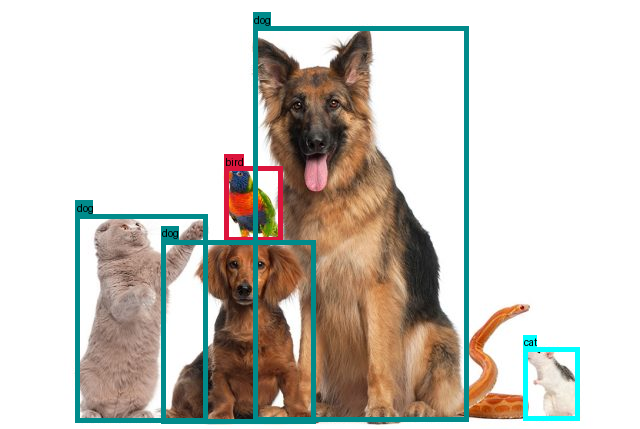

 -- Objetos mostrados: 5 de 100 detectados total
 -- Tiempo de procesamiento: 61.96 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/asado.jpg


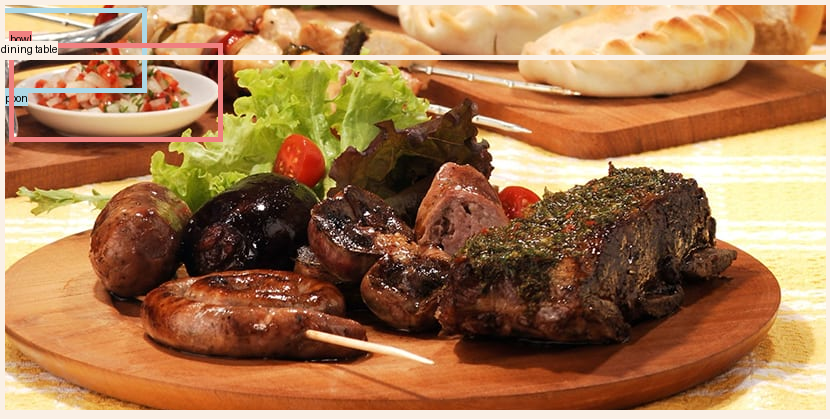

 -- Objetos mostrados: 4 de 100 detectados total
 -- Tiempo de procesamiento: 54.29 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/plazaMayo.jpg


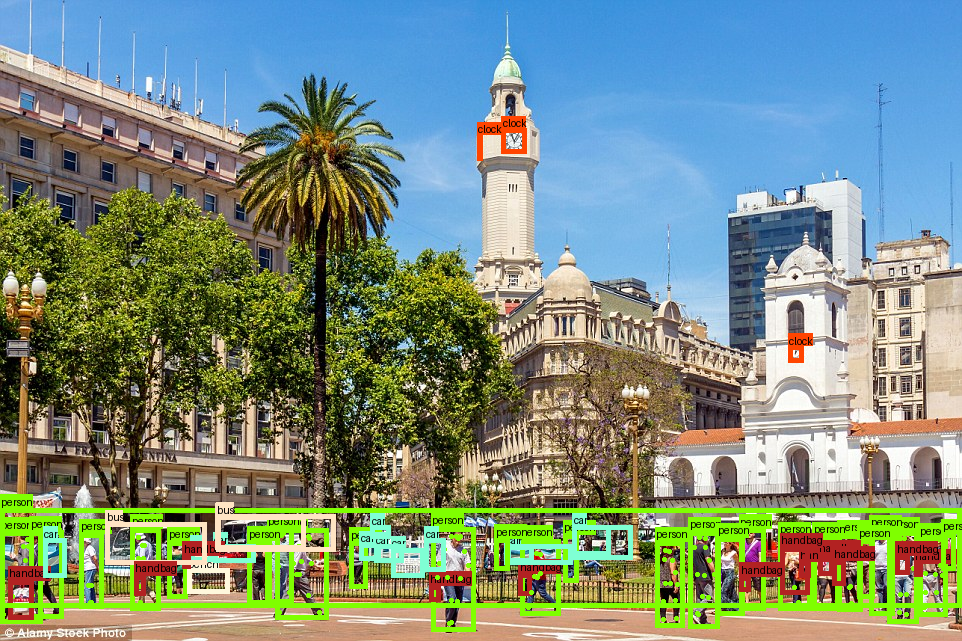

 -- Objetos mostrados: 58 de 100 detectados total
 -- Tiempo de procesamiento: 54.24 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/laBoca.jpg


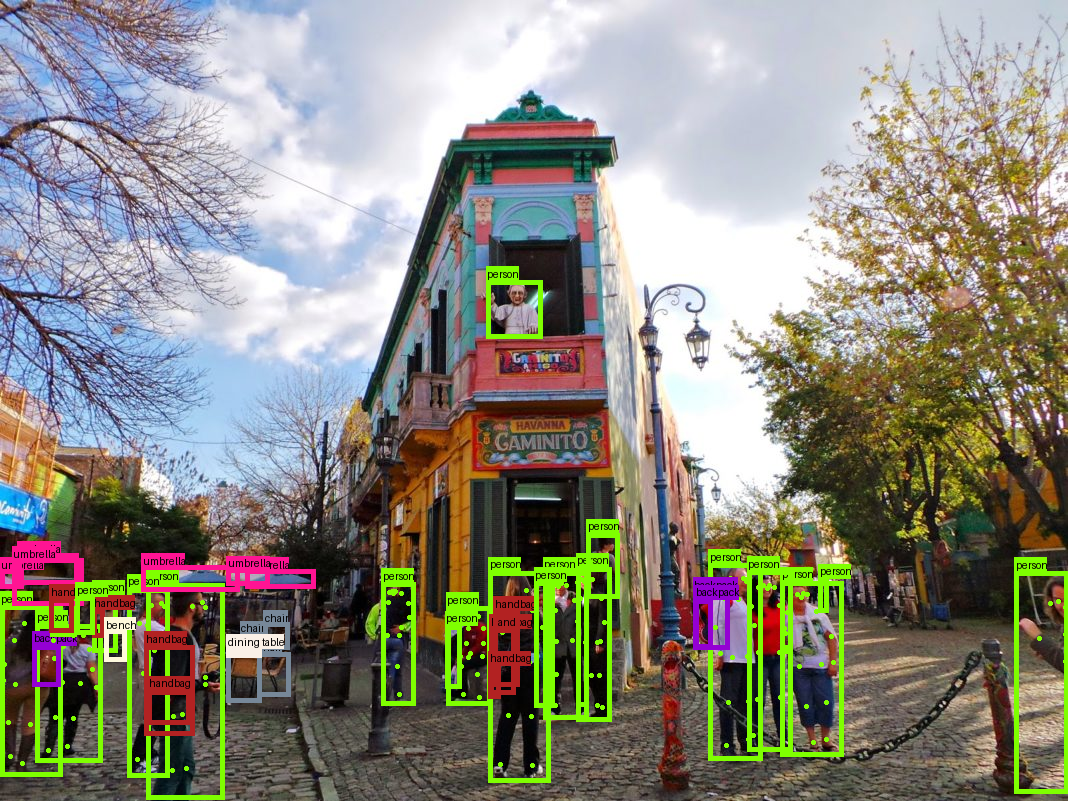

 -- Objetos mostrados: 44 de 100 detectados total
 -- Tiempo de procesamiento: 55.53 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/festival.jpg


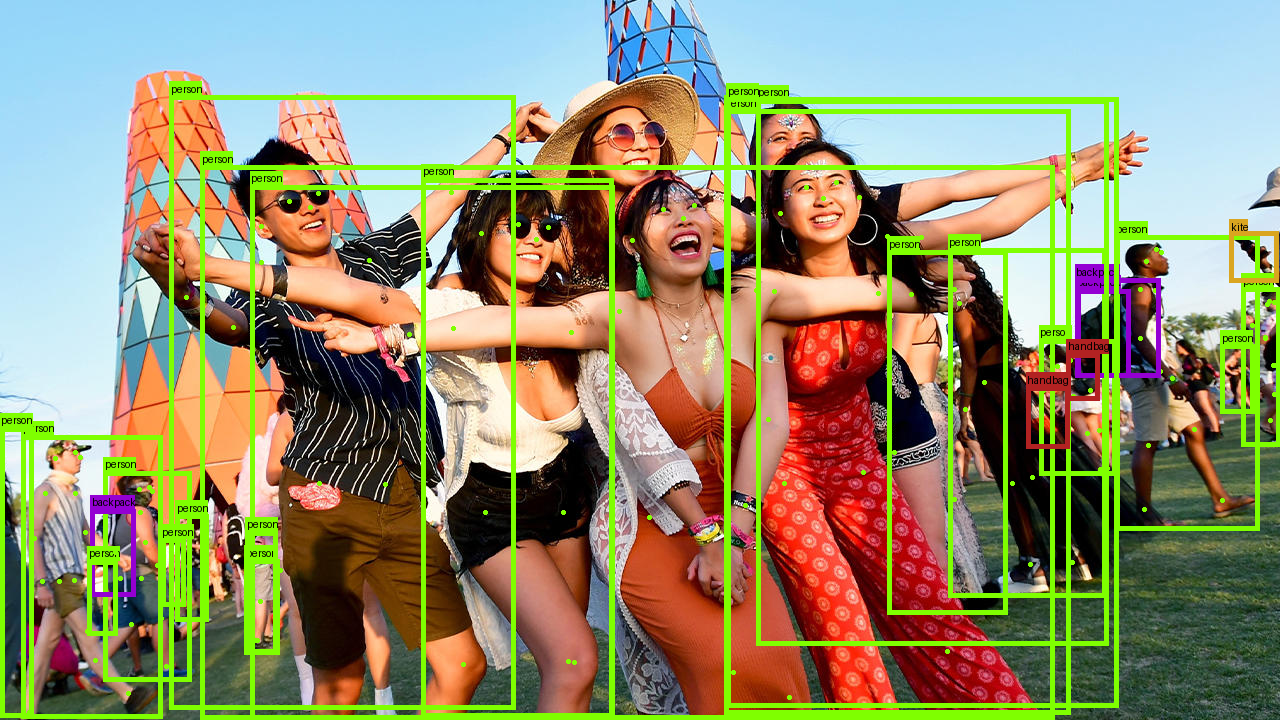

 -- Objetos mostrados: 27 de 100 detectados total
 -- Tiempo de procesamiento: 53.86 segundos 

-----------------------------------------------------------------------------


*  gdrive/My Drive/IA/demoML/imagenes/MUCHOS/obelisco.jpg


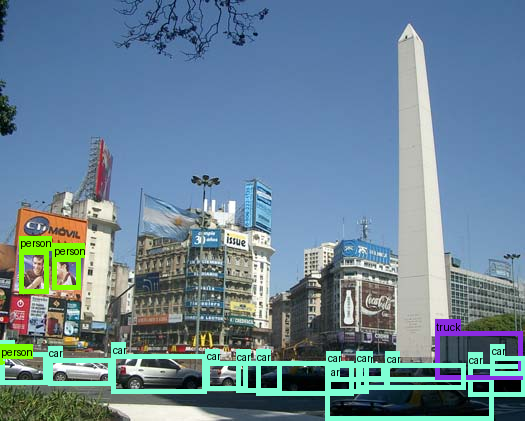

 -- Objetos mostrados: 17 de 100 detectados total
 -- Tiempo de procesamiento: 64.66 segundos 

-----------------------------------------------------------------------------



In [15]:
#@title Procesar imágenes por el modelo seleccionado

# define la minima probabilidad que se va a usar para detectar objetos
drive_minimaProbabilidad = 24 #@param {type:"slider", min:0, max:100, step:1}

drive_mostrar_tiempo_ejecucion = True
drive_mostrar_subimagenes_objetos = False #@param {type:"boolean"}

# indica si muestra detalle de resultados o no
print("> Modelo ", seleccionar_modelo, ":\n")

# procesalas imágenes cargadas
for name_img, img in zip(all_imagesName_array, all_imagesInfo_array):
  print("\n* ", name_img)
  procesarImagenNP(HubModel,
                   category_index,
                   img,
                   drive_minimaProbabilidad/100,
                   drive_mostrar_tiempo_ejecucion,
                   drive_mostrar_subimagenes_objetos)

  print("\n-----------------------------------------------------------------------------\n")

> Modelo  CenterNet HourGlass104 Keypoints 1024x1024 :



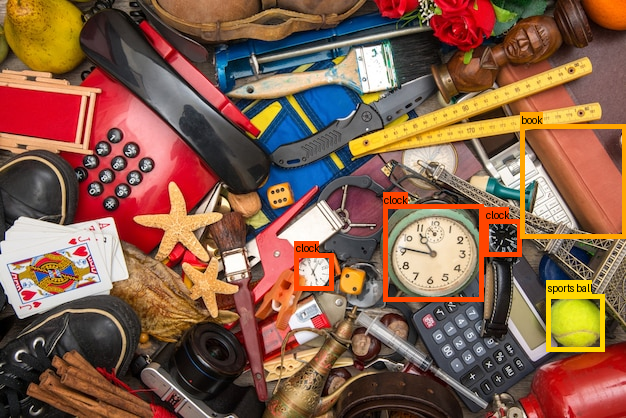

 -- Objetos mostrados: 5 de 100 detectados total
 -- Tiempo de procesamiento: 54.24 segundos 

 ** Sub-Imágenes:

	* clase  clock con 77.0 % en box  (np.float32(383.46515), np.float32(204.72894), np.float32(483.68417), np.float32(301.22687))

	  incluye keypoints 0 mostrados 


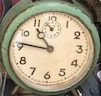


	* clase  clock con 67.4 % en box  (np.float32(484.85907), np.float32(219.5709), np.float32(521.18256), np.float32(256.63605))

	  incluye keypoints 0 mostrados 


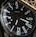


	* clase  sports ball con 47.6 % en box  (np.float32(546.9424), np.float32(294.73715), np.float32(604.4043), np.float32(351.7766))

	  incluye keypoints 0 mostrados 


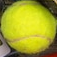


	* clase  clock con 36.8 % en box  (np.float32(294.59216), np.float32(253.2717), np.float32(333.39374), np.float32(290.66003))

	  incluye keypoints 0 mostrados 


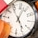


	* clase  book con 26.7 % en box  (np.float32(520.386), np.float32(124.98241), np.float32(626.0), np.float32(238.69304))

	  incluye keypoints 0 mostrados 


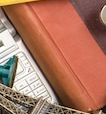

In [16]:
#@title Procesar imagen desde URL

import requests # request img from web
import shutil # save img locally

imagen_URL = "https://img.freepik.com/fotos-premium/muchos-objetos-caos_100488-936.jpg?semt=ais_hybrid" #@param {type:"string"}

URL_minimaProbabilidad = 25 #@param {type:"slider", min:0, max:100, step:1}

URL_mostrar_tiempo_ejecucion = True
URL_mostrar_subimagenes_objetos = True


if imagen_URL != "":
    try:
      # baja la imagen
      URL_file_name = "./donwload_image.jpg"
      res = requests.get(imagen_URL, stream = True)
      if res.status_code == 200:
          with open(URL_file_name,'wb') as f:
              shutil.copyfileobj(res.raw, f)
      else:
          print('No se puede descargar la imagen')
    except Exception as e:
      print("Error al descargar la imagen: ", e)
      URL_file_name = None

    # abre la imagen
    if URL_file_name is not None:
        URL_imag = Image.open(URL_file_name)

        # indica si muestra detalle de resultados o no
        print("> Modelo ", seleccionar_modelo, ":\n")

        procesarImagenNP(HubModel,
                        category_index,
                        URL_imag,
                        URL_minimaProbabilidad/100,
                        URL_mostrar_tiempo_ejecucion,
                        URL_mostrar_subimagenes_objetos)